In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import quantumaudio as qa
from pydub import AudioSegment

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import qiskit.quantum_info as qi

In [2]:
#Reading the audio file
audio = AudioSegment.from_file('Cello.pizz.ff.sulC.C2.stereo.aif') 
audio = audio.set_frame_rate(10000)
sample_rate = audio.frame_rate
data = audio.get_array_of_samples()[:]
n = len(data)

In [3]:
#Making the data 2**N
total_qubits = 12
data = data[:2**total_qubits]
data = data/np.linalg.norm(data)
N = len(data)

In [4]:
n

72794

(0.2, 0.45)

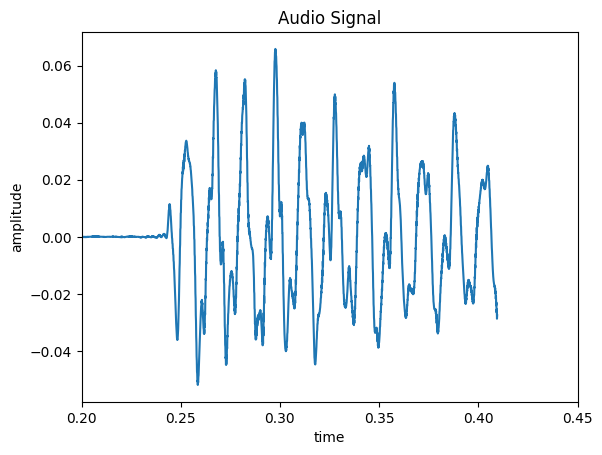

In [6]:
#Plotting the Audio Signal 
time = np.arange(len(data))/sample_rate
plt.plot(time,data)
plt.title('Audio Signal')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.xlim(0.2,0.45)

## Classical Fourier transform

In [27]:
#Obtaining Fourier spectrum classically
fft = np.fft.fft(data)

## Quantum Fourier transform

In [8]:
#Defining qft algorithm
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

For this input, the QPAM representation will require:
         12 qubits for encoding time information and 
         0 qubits for encoding ampĺitude information.


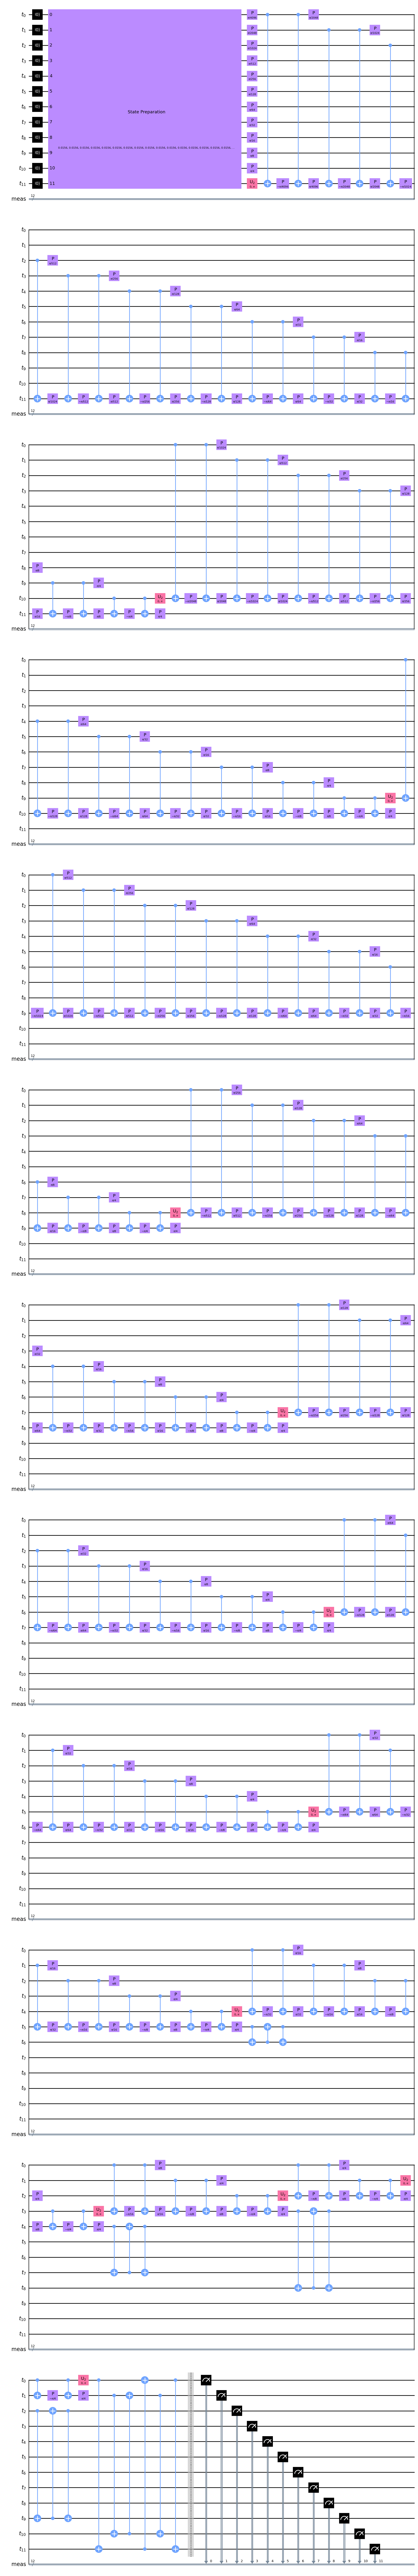

In [8]:
#Encoding the data array on the quantum circuit by using 'qpam' method - which takes the input data, normalizes it and initializes on circuit of n qubits

qr = QuantumRegister(total_qubits)
qc = QuantumCircuit(qr)
qsound_qpam = qa.QuantumAudio('qpam')
qsound_qpam.load_input(data)
qsound_qpam.prepare()
qc = qsound_qpam.circuit

#Creating a circuit with quantum fourier transform alogithm
qft_circuit=qft(total_qubits)

#Merging both the initialized circuit and qft circuit
audio_qc = qc.compose(qft_circuit,list(np.arange(total_qubits)))

#Measuring the qubits to get the classical results
audio_qc.measure_all()
audio_qc.decompose().draw('mpl')

In [9]:
#Using my IBM Quantum Experience account to access the quantum simulator online
from qiskit_ibm_runtime import Estimator, QiskitRuntimeService, Sampler, Session, Options

service = QiskitRuntimeService(
     channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='84e47768480771b0f65f16b3f25447e5ab6b88d174cccb8271d1d0a3e4fdf3ce875e7f9f2612ad64f6f107644f49d8c6d9cd2619469de103753b4ae7556e703a'
)
backend = service.backend('ibmq_qasm_simulator') #A particular quantum simulator to run my circuit and get results

In [11]:
#DO NOT EXECUTE THIS CELL
#Executing the circuit in the chosen backend
#options = Options()
#options.execution.shots = 10000
#sampler = Sampler(options=options,backend=backend)
#job = sampler.run(audio_qc)               #Submitting the job to the backend
#result = job.result()                     #Extracting the results from the job once it is executed successfully

In [10]:
def get_fft_from_counts(counts, n_qubits):
    out = []
    keys = counts.keys()
    for id in range(2**n_qubits):
        if(id in keys):
            out.append(counts[id])
        else:
            out.append(0)
    return out

In [11]:
#Calling the job executed above with its job_id
job = service.job('clvvtd0iidfp3m85u3og')
result = job.result()

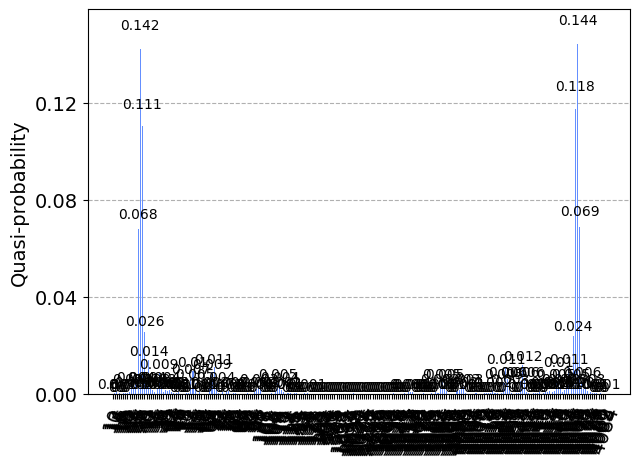

In [12]:
#plotting the probability histogram obtained (in this case this is the absolute value of fourier coefficients)
counts = result.quasi_dists
plot_histogram(counts)

In [22]:
qft = get_fft_from_counts(counts[0],total_qubits)
qft  = [i*len(data) for i in qft]    #Rescaling the normalization done before (Denormalization)
N = len(qft)
freq = np.arange(N)*sample_rate/N

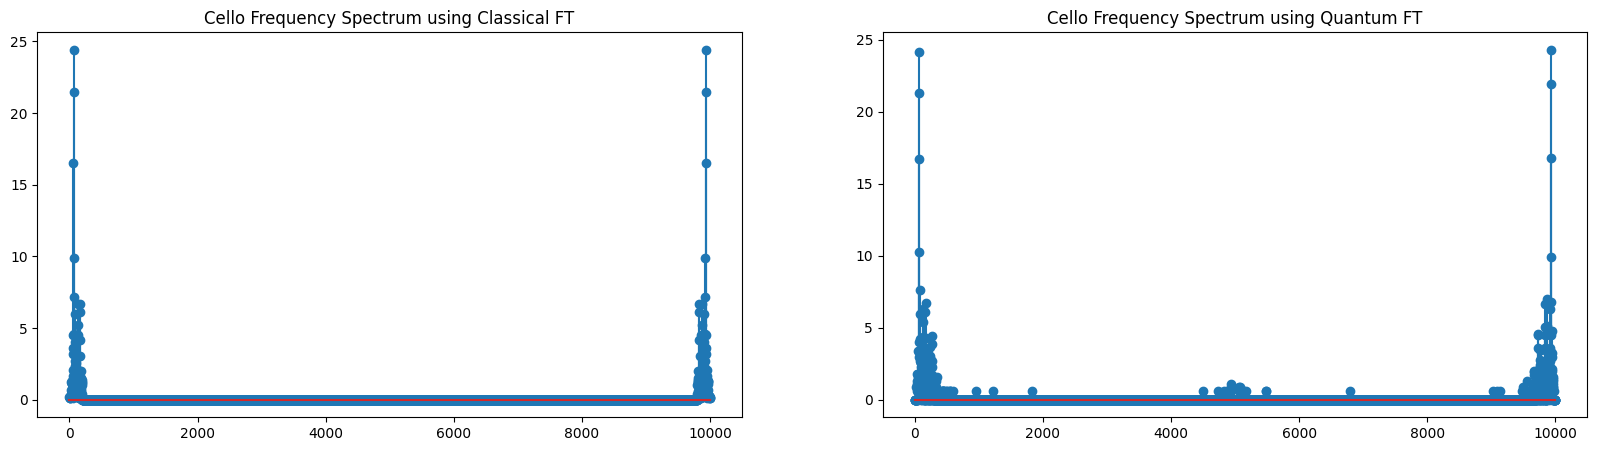

In [23]:
#Comparing Fourier spectrum from both
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.stem(freq,np.abs(fft))
plt.title('Cello Frequency Spectrum using Classical FT')

plt.subplot(1,2,2)
plt.stem(freq,np.sqrt(qft))
plt.title('Cello Frequency Spectrum using Quantum FT')

plt.subplots_adjust(wspace=0.2)

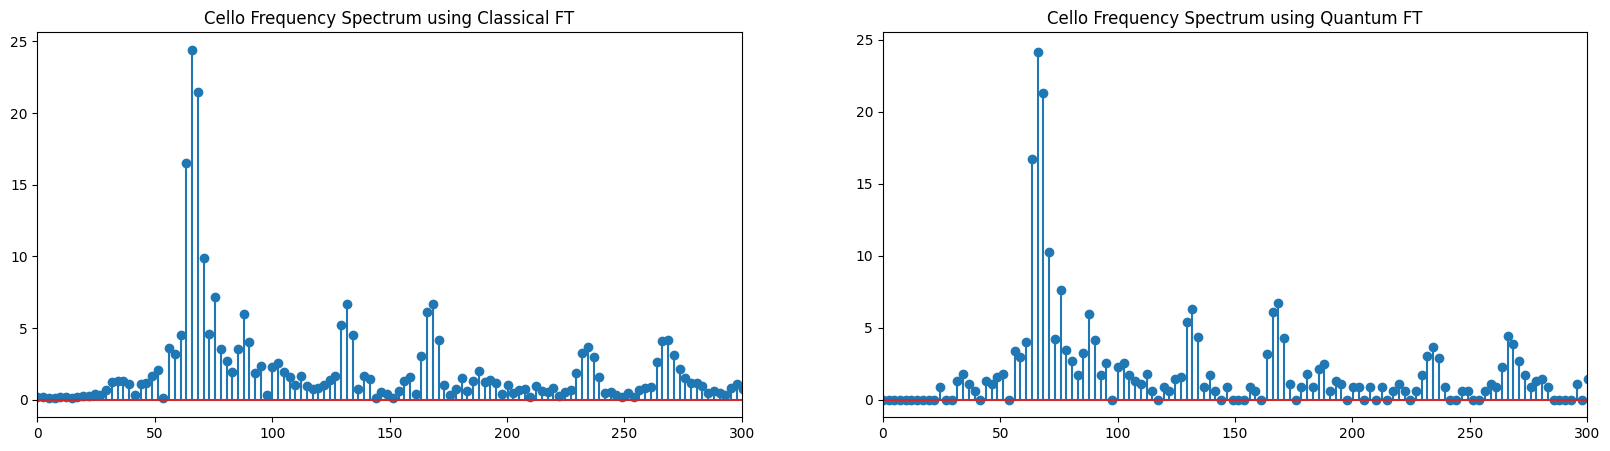

In [33]:
#Comparing Fourier spectrum from both
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.stem(freq,np.abs(fft))
plt.title('Cello Frequency Spectrum using Classical FT')
plt.xlim(0,300)

plt.subplot(1,2,2)
plt.stem(freq,np.sqrt(qft))
plt.title('Cello Frequency Spectrum using Quantum FT')
plt.xlim(0,300)

plt.subplots_adjust(wspace=0.2)

In [29]:
#Finding the top 3 frequencies from both
abs_fft = [np.abs(i) for i in fft[:int(len(fft)/2)]]
abs_qft = [i for i in fft[:int(len(qft)/2)]]
           

indices_of_max_values_qft = np.argsort(abs_qft)[-3:][::-1]
indices_of_max_values_fft = np.argsort(abs_fft)[-3:][::-1]
qft_max = [freq[i] for i in indices_of_max_values_qft]
fft_max = [freq[i] for i in indices_of_max_values_fft]
print('Max 3 frequencies of the audio obtained using the Quantum FT is',qft_max)
print('Max 3 frequencies of the audio obtained using the Classical FT is',fft_max)

Max 3 frequencies of the audio obtained using the Quantum FT is [70.80078125, 61.03515625, 63.4765625]
Max 3 frequencies of the audio obtained using the Classical FT is [65.91796875, 68.359375, 63.4765625]


In [31]:
#Calculating power spectrum
power_spectrum_classical = [np.abs(i)**2 for i in fft]

total_power_classical = np.sum(power_spectrum_classical)
total_power_quantum = np.sum(qft)
print('Total power of the audio obtained using the Quantum FT is',total_power_quantum)
print('Total power of the audio obtained using the Classical FT is',total_power_classical)

Total power of the audio obtained using the Quantum FT is 4096.0
Total power of the audio obtained using the Classical FT is 4096.0


## Filtering

In [15]:
def lowpass_filter(qft,sample_rate,bandwidth):
    N = len(qft)
    freq = np.arange(N)*sample_rate/N
    cutoff_index = math.ceil(bandwidth*N/sample_rate)
    for i in range(cutoff_index+1,N-cutoff_index):
        qft[i] = 0
    return qft

In [16]:
filtered_qft = lowpass_filter(qft,sample_rate,200)
filtered_qft  = [i*len(data) for i in filtered_qft]

In [17]:
filtered_fft = lowpass_filter(fft,sample_rate,200)

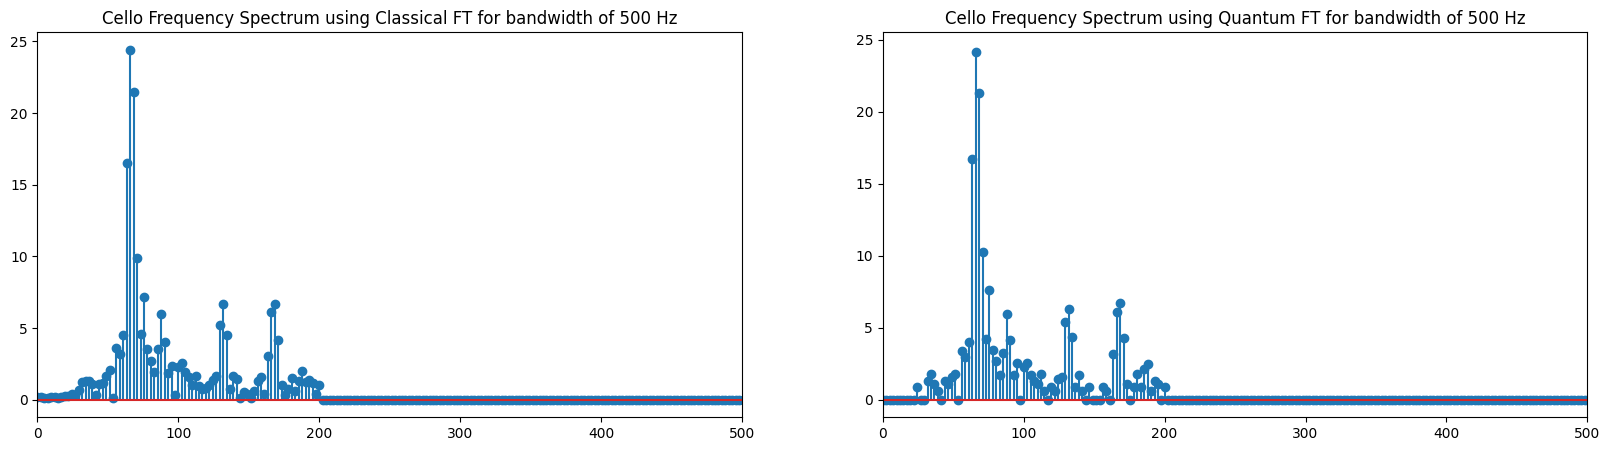

In [32]:
#Comparing Fourier spectrum from both
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.stem(freq,np.abs(filtered_fft))
plt.title('Cello Frequency Spectrum using Classical FT for bandwidth of 500 Hz')
plt.xlim(0,500)

plt.subplot(1,2,2)
plt.stem(freq,np.sqrt(filtered_qft))
plt.title('Cello Frequency Spectrum using Quantum FT for bandwidth of 500 Hz')
plt.xlim(0,500)

plt.subplots_adjust(wspace=0.2)

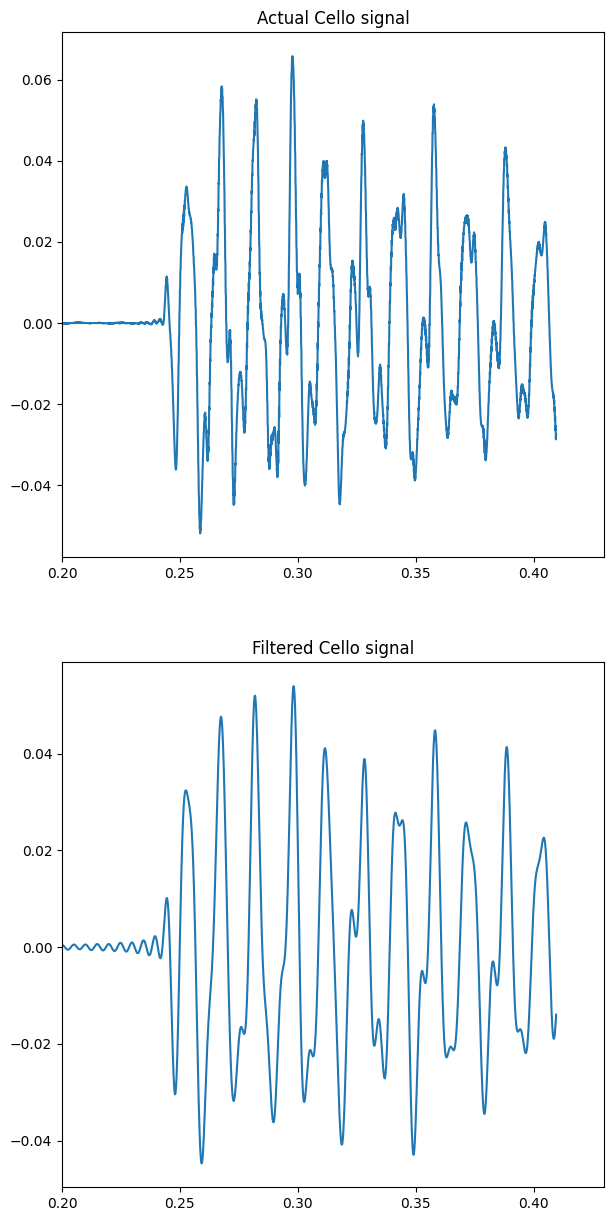

In [21]:
filtered_signal = np.fft.ifft(filtered_fft)
#Comparing filtered signal
plt.figure(figsize=(7, 15))
plt.subplot(2,1,1)
plt.plot(time,np.real(data))
plt.title('Actual Cello signal')
plt.xlim(0.2,0.43)

plt.subplot(2,1,2)
plt.plot(time,np.real(filtered_signal))
plt.title('Filtered Cello signal')
plt.xlim(0.2,0.43)

plt.subplots_adjust(wspace=0.2)